### Import Libraries

In [1]:
from keras.models import load_model
import pickle
import cv2
import numpy as np
import cvlib as cv
from PIL import Image

import matplotlib.pyplot as plt
from cvlib.object_detection import draw_bbox
%matplotlib inline

#### Loading Trained Model

In [2]:
loaded_model=load_model('FruitClassifier.h5')

In [3]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 48)        3648      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 112)       134512    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 88, 88, 112)       313712    
_________________________________________________________________
flatten (Flatten)            (None, 867328)            0         
_________________________________________________________________
dense (Dense)                (None, 48)                41631792  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 49        
Total params: 42,083,713
Trainable params: 42,083,713
Non-trainable params: 0
____________________________________________

In [4]:
def predict_class(img):
    img=cv2.resize(img, (100,100))
    img=img/255
    Img=img.reshape(1,100,100,3)
    for i in loaded_model.predict(Img):
        for j in i:
            if i >= 0.5:
                return 'Rotten'
            else:
                return 'Fresh'

In [5]:
def classify_fruit(img):  # input as openCV image
    # converting openCV to PIL for cropping
    Img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    PIL_img = Image.fromarray(Img)
    
    coor, label, conf = cv.detect_common_objects(img)    # detectimg fruit
    for i in coor:
        for j in label:
            if j == 'orange' or j == 'apple' or j == 'banana':      # checking for our 3 classes apple, banana, oranges
                x,y,w,h = i
                roi = PIL_img.crop((i))                            # cropping Image to find roi (region of interest)
                roi = np.asarray(roi)
                if predict_class(roi) == 'Rotten':
                    cv2.rectangle(img, (x,y), (w,h), (0,0,255), 2)
                    cv2.putText(img, 'Rotten', (x+5, y+18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255), 2)
                elif predict_class(roi) == 'Fresh':
                    cv2.rectangle(img, (x,y), (w,h), (0,255,0), 2)
                    cv2.putText(img, 'Fresh', (x+5, y+18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0), 2)
                    
    return img

#### Testing on Image

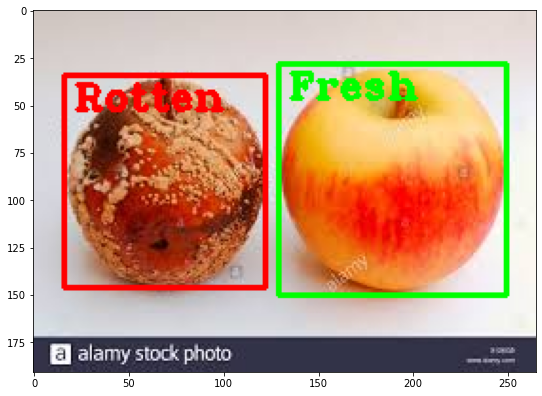

In [6]:
img = cv2.imread('download.jpg')
plt.figure(figsize=(9,9))
image=cv2.cvtColor(classify_fruit(img), cv2.COLOR_BGR2RGB)
plt.imshow(image)

#### Testing on Video

In [ ]:
cap = cv2.VideoCapture('Orange Timelapse.mp4')
cap.set(cv2.CAP_PROP_FPS,15)
fps = int(cap.get(5))
print(f'fps : {fps}')


width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer= cv2.VideoWriter('real_insta.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 30, (width, height))

if cap.isOpened() == False:
    print('Error in opening video!!')
else:
    while cap.isOpened()==True:
        ret, image = cap.read()
        if ret==True:
            cv2.imshow('Window', classify_fruit(image))
            writer.write(classify_fruit(image))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
cap.release()
writer.release()
cv2.destroyAllWindows()